In [1]:
!pip install tensorflow_datasets -q

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds
from Classifier import Classifier
from DataGenerator import DataGenerator


def set_seed(seed=42):
#     random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed = 42
set_seed(seed)


# prepare train, val, test sets from jersey dataset

In [3]:
dataset = pd.read_csv("../data/players_number/train_player_numbers.csv")
# update the path to the images
dataset["filepath"] = dataset["filepath"].apply(lambda x: "../data/players_number/"+x)

In [4]:
# number of samples varies for different numbers
print(dataset.groupby("label").agg("count"))
# smallest number of samples
min_count = dataset.groupby("label").agg("count").min()["filename"]
print(min_count)

       filename  video_frame  player  left   top  right  bottom  filepath
label                                                                    
0           130          130     130   130   130    130     130       130
1            70           70      70    70    70     70      70        70
2            99           99      99    99    99     99      99        99
3           110          110     110   110   110    110     110       110
4           116          116     116   116   116    116     116       116
...         ...          ...     ...   ...   ...    ...     ...       ...
95          552          552     552   552   552    552     552       552
96          633          633     633   633   633    633     633       633
97          838          838     838   838   838    838     838       838
98         1008         1008    1008  1008  1008   1008    1008      1008
99          735          735     735   735   735    735     735       735

[100 rows x 8 columns]
24


In [5]:
# randomly sample n samples with n=smallest number of samples 
subset = dataset.groupby("label").sample(n=min_count, replace=False, random_state=seed)

In [6]:
# one-hot encoding to use categorical cross entropy, not needed if sparse cat cross entropy
subset = pd.concat([subset, pd.get_dummies(subset["label"], prefix="n")], axis=1)

In [7]:
onehot_labels = [f"n_{i}" for i in range(100)]

In [8]:
# split the number into 2 digits
subset["first_digit"] = subset["label"].apply(lambda x: int(f'{x:02d}'[0]))
subset["second_digit"] = subset["label"].apply(lambda x: int(f'{x:02d}'[1]))

In [9]:
train, test = train_test_split(subset, test_size=0.3, random_state=seed, shuffle=True)
test, val = train_test_split(test, test_size=0.3, random_state=seed, shuffle=True)

make TF data generators

In [10]:
DG = DataGenerator()

train_ds = DG.get_dataset(
    filenames=train["filepath"].to_numpy(), 
    labels=(train["first_digit"].to_numpy(), train["second_digit"].to_numpy()),
    batch_size=32, 
    n_prefetch=1,
    training=True
)

val_ds = DG.get_dataset(
    filenames=val["filepath"].to_numpy(), 
    labels=(val["first_digit"].to_numpy(), val["second_digit"].to_numpy()),
    training=False

)

test_ds = DG.get_dataset(
    filenames=test["filepath"].to_numpy(), 
    labels=(test["first_digit"].to_numpy(), test["second_digit"].to_numpy()),
    training=False
)

2022-01-05 10:28:29.512042: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
for t in train_ds:
    break
    

2022-01-05 10:28:41.219063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# Prepare double MNIST dataset to pretrain the network on a larger dataset

https://github.com/shaohua0116/MultiDigitMNIST

In [29]:
def get_files(path, extensions=(".png", ".jpeg", ".jpg")):
    results = []
    for r, d, files in os.walk(path):
        for f in files:
            if f.endswith(extensions):
                results.append(os.path.join(r, f))
    return results

pngs = get_files(path="../data/double_mnist_seed_123_image_size_64_64", extensions=(".png"))
ds = []
for png in pngs:
    basename = os.path.splitext(os.path.basename(png))[0]
    label = basename.split("_")[-1]
    ds.append([png, int(label), int(label[0]), int(label[1])])
ds_mnist = pd.DataFrame(ds, columns=["path", "group", "digit_1", "digit_2"])

In [35]:
mnist_train = ds_mnist.groupby("group").sample(frac=0.9, replace=False)
mnist_test = ds_mnist.drop(index=mnist_train.index)

In [36]:
DG = DataGenerator()

mnist_train = DG.get_dataset(
    filenames=mnist_train["path"].to_numpy(), 
    labels=(mnist_train["digit_1"].to_numpy(), mnist_train["digit_2"].to_numpy()), 
    batch_size=32, 
    n_prefetch=1,
    training=True
)

mnist_test = DG.get_dataset(
    filenames=mnist_test["path"].to_numpy(), 
    labels=(mnist_test["digit_1"].to_numpy(), mnist_test["digit_2"].to_numpy())
)

# squeeze rgb image into grayscale and back to rgb
# this is because the model expects 3 channel image, but we use double digit MNIST which is grayscale

mnist_train = mnist_train.map(lambda image, label: (tf.image.rgb_to_grayscale(image), label))
mnist_train = mnist_train.map(lambda image, label: (tf.image.grayscale_to_rgb(image), label))

mnist_test = mnist_test.map(lambda image, label: (tf.image.rgb_to_grayscale(image), label))
mnist_test = mnist_test.map(lambda image, label: (tf.image.grayscale_to_rgb(image), label))

In [33]:
mnist_train = mnist_train.map(lambda image, label: (tf.image.rgb_to_grayscale(image), label))
mnist_train = mnist_train.map(lambda image, label: (tf.image.grayscale_to_rgb(image), label))

<MapDataset shapes: ((None, 64, 64, 1), ((None,), (None,))), types: (tf.float32, (tf.int64, tf.int64))>

In [23]:
t = next(iter(mnist_train))

In [36]:
plt.imread("/workspace/workdir/projects/playground/data/double_mnist_seed_123_image_size_64_64/00/0_00.png").shape

(64, 64)

In [23]:
filename = "/workspace/workdir/projects/playground/data/double_mnist_seed_123_image_size_64_64/00/0_00.png"
filename = "/workspace/workdir/projects/playground/data/players_number/train_player_numbers/57583_000082_Endzone_20_H27.png"
image_string = tf.io.read_file(filename)
image = tf.image.decode_jpeg(image_string, channels=3)
image = tf.image.rgb_to_grayscale(image)
image = tf.image.grayscale_to_rgb(image)
# image = tf.image.convert_image_dtype(image, tf.float32)

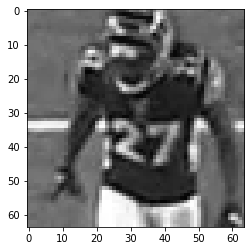

In [24]:
plt.imshow(image)

# Make classifier

In [27]:
classifier = Classifier()
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
classifier.model.compile(loss=["sparse_categorical_crossentropy", "sparse_categorical_crossentropy"],
    loss_weights=[0.5, 0.5],
    optimizer=opt, 
    metrics=["accuracy"])

# callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("./model_weights/model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

classifier.model.fit(mnist_train, validation_data=mnist_test, epochs=50)#, callbacks=[checkpoint_cb, early_stopping_cb])

In [28]:
classifier.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_4_input (InputLayer)     [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 62, 62, 32)   896         conv2d_4_input[0][0]             
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 31, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 31, 32)   0           max_pooling2d[0][0]              
____________________________________________________________________________________________

In [22]:
# tf.keras.models.save_model(classifier.model, "saved_model")

2022-01-03 21:44:33.405400: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/assets


In [33]:
model = tf.keras.models.load_model("saved_model")
opt = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9)
model.compile(loss=["sparse_categorical_crossentropy", "sparse_categorical_crossentropy"],
    loss_weights=[0.5, 0.5],
    optimizer=opt, 
    metrics=["accuracy"])
model

In [34]:
model.fit(train_ds, validation_data=val_ds, epochs=50)

Epoch 1/50
53/53 [==============================] - 3s 57ms/step - loss: 5.0723 - dense_2_loss: 4.9316 - dense_3_loss: 5.2130 - dense_2_accuracy: 0.1048 - dense_3_accuracy: 0.1095 - val_loss: 3.7135 - val_dense_2_loss: 3.6896 - val_dense_3_loss: 3.7373 - val_dense_2_accuracy: 0.0972 - val_dense_3_accuracy: 0.0741
Epoch 2/50
53/53 [==============================] - 3s 56ms/step - loss: 3.9447 - dense_2_loss: 3.9399 - dense_3_loss: 3.9496 - dense_2_accuracy: 0.0976 - dense_3_accuracy: 0.1083 - val_loss: 3.1938 - val_dense_2_loss: 3.2158 - val_dense_3_loss: 3.1718 - val_dense_2_accuracy: 0.0926 - val_dense_3_accuracy: 0.0926
Epoch 3/50
53/53 [==============================] - 3s 57ms/step - loss: 3.4876 - dense_2_loss: 3.5038 - dense_3_loss: 3.4715 - dense_2_accuracy: 0.0958 - dense_3_accuracy: 0.1101 - val_loss: 2.9741 - val_dense_2_loss: 2.9988 - val_dense_3_loss: 2.9494 - val_dense_2_accuracy: 0.1019 - val_dense_3_accuracy: 0.0972
Epoch 4/50
53/53 [==============================] - 3s 

Epoch 27/50
53/53 [==============================] - 3s 58ms/step - loss: 2.5169 - dense_2_loss: 2.5319 - dense_3_loss: 2.5019 - dense_2_accuracy: 0.1113 - dense_3_accuracy: 0.1173 - val_loss: 2.4083 - val_dense_2_loss: 2.4000 - val_dense_3_loss: 2.4166 - val_dense_2_accuracy: 0.1065 - val_dense_3_accuracy: 0.1157
Epoch 28/50
53/53 [==============================] - 3s 58ms/step - loss: 2.5179 - dense_2_loss: 2.5213 - dense_3_loss: 2.5146 - dense_2_accuracy: 0.1048 - dense_3_accuracy: 0.1220 - val_loss: 2.4041 - val_dense_2_loss: 2.3957 - val_dense_3_loss: 2.4125 - val_dense_2_accuracy: 0.1065 - val_dense_3_accuracy: 0.1157
Epoch 29/50
53/53 [==============================] - 3s 59ms/step - loss: 2.5117 - dense_2_loss: 2.5168 - dense_3_loss: 2.5066 - dense_2_accuracy: 0.0929 - dense_3_accuracy: 0.1048 - val_loss: 2.4003 - val_dense_2_loss: 2.3920 - val_dense_3_loss: 2.4087 - val_dense_2_accuracy: 0.1065 - val_dense_3_accuracy: 0.1157
Epoch 30/50
53/53 [==============================] -

# try transfer learning from xception pretrained on imagenet

classify first and second digit separately

In [89]:
# split the number into 2 digits
subset["first_digit"] = subset["label"].apply(lambda x: int(f'{x:02d}'[0]))
subset["second_digit"] = subset["label"].apply(lambda x: int(f'{x:02d}'[1]))


train, test = train_test_split(subset, test_size=0.3, random_state=seed, shuffle=True)
test, val = train_test_split(test, test_size=0.3, random_state=seed, shuffle=True)

In [101]:
DG = DataGenerator()

train_ds = DG.get_dataset(
    filenames=train["filepath"].to_numpy(), 
    labels=(train["first_digit"].to_numpy(), train["second_digit"].to_numpy()),
    batch_size=5, 
    n_prefetch=1,
    training=True
)

val_ds = DG.get_dataset(
    filenames=val["filepath"].to_numpy(), 
    labels=(val["first_digit"].to_numpy(), val["second_digit"].to_numpy()))

test_ds = DG.get_dataset(
    filenames=test["filepath"].to_numpy(), 
    labels=(test["first_digit"].to_numpy(), test["second_digit"].to_numpy()))

In [25]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
# base_modle = tf.keras.applications.EfficientNetB0(weights="imagenet", include_top=False)

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
first_digit_output = tf.keras.layers.Dense(10, activation="softmax")(avg)
second_digit_output = tf.keras.layers.Dense(10, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=[first_digit_output, second_digit_output])

# freeze the weights
for layer in base_model.layers:
    layer.trainable = False

83697664/83683744 [==============================] - 8s 0us/step


In [26]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [103]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(
    loss=["sparse_categorical_crossentropy", "sparse_categorical_crossentropy"],
    loss_weights=[0.5, 0.5],
    optimizer=optimizer, 
    metrics=["accuracy"]
)

In [104]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
336/336 [==============================] - 18s 48ms/step - loss: 2.4620 - dense_24_loss: 2.4265 - dense_25_loss: 2.4974 - dense_24_accuracy: 0.1423 - dense_25_accuracy: 0.1173 - val_loss: 2.4705 - val_dense_24_loss: 2.4083 - val_dense_25_loss: 2.5327 - val_dense_24_accuracy: 0.1713 - val_dense_25_accuracy: 0.1481
Epoch 2/5
336/336 [==============================] - 17s 51ms/step - loss: 2.1838 - dense_24_loss: 2.1465 - dense_25_loss: 2.2210 - dense_24_accuracy: 0.2351 - dense_25_accuracy: 0.2012 - val_loss: 2.3844 - val_dense_24_loss: 2.3225 - val_dense_25_loss: 2.4462 - val_dense_24_accuracy: 0.1574 - val_dense_25_accuracy: 0.1296
Epoch 3/5
336/336 [==============================] - 16s 48ms/step - loss: 2.0189 - dense_24_loss: 1.9891 - dense_25_loss: 2.0487 - dense_24_accuracy: 0.2958 - dense_25_accuracy: 0.2774 - val_loss: 2.3838 - val_dense_24_loss: 2.3241 - val_dense_25_loss: 2.4436 - val_dense_24_accuracy: 0.1991 - val_dense_25_accuracy: 0.1389
Epoch 4/5
336/336 [======